# Food Classifier

### In this project we will be using CNN models to predict the food in images.

In this notebook, we will be using food-5k, which includes 2 classes.

This notebook was run in Google Colab and is best run using GPUs as the data augmentation section takes quite some time to run.

## Importing libraries

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy.random import seed

seed(1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     SeparableConv2D, ReLU, MaxPooling2D, Add, Input,
                                     BatchNormalization, MaxPool2D, GlobalAvgPool2D,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims


from PIL import Image
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import requests
import datetime
import os

In [ ]:
# printing GPU info to make sure the GPU is being utilized
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 23 00:01:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# printing available RAM to make sure it's enough
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Reading in the data

In [ ]:
# loading in Google Drive to retrieve the dataset(s)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# creating a path variable for the data subset we'll be modeling on
img_path = "/content/drive/My Drive/Capstone/food-5k/training"
img_size = 256
img_size_tup = (256, 256)

# loading the images from the path into a train_data variable while resizing the images and splitting the data
# color mode will be 'rgb' which is 3 colors
# labels are 'categorical' since there are more than 2 categories
train_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path, 
          labels='inferred',
          label_mode='categorical', 
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=None,
          # subset='training',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 2999 files belonging to 2 classes.


In [ ]:
# loading the images for validation from the above split into a test_data variable while resizing same as above 

img_path_val = "/content/drive/My Drive/Capstone/food-5k/validation"

test_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path_val,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=None,
          # subset='validation',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 1000 files belonging to 2 classes.


In [ ]:
# looking at our train_data variable to see shape and type
train_data

<BatchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [ ]:
# creating variable for class names
class_names = test_data.class_names

# creating variable for number of classes
n_classes = len(train_data.class_names)
n_classes, class_names

(2, ['food', 'non_food'])

# EDA & Preprocessing the Data

In [ ]:
# function for preprocessing our data into X, y as numpy arrays that are rescaled between 0-1
def preprocess_img_input(batch_dataset):
    for images, labels in batch_dataset.take(1):  # only take first element of dataset
        X = images.numpy()
        y = labels.numpy()

        X /= 255

        return X, y

# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
X_train, y_train = preprocess_img_input(train_data)
X_test, y_test = preprocess_img_input(test_data)

In [ ]:
# checking our x and y
X_train[0][0][0], y_train[0]

(array([0.79509807, 0.8656863 , 0.904902  ], dtype=float32),
 array([1., 0.], dtype=float32))

In [ ]:
# checking the shape of X_train
X_train.shape

(32, 256, 256, 3)

In [ ]:
# checking the shape of y_train
y_train.shape

(32, 2)

In [ ]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape = X_train[0].shape

# Visualizing the Data

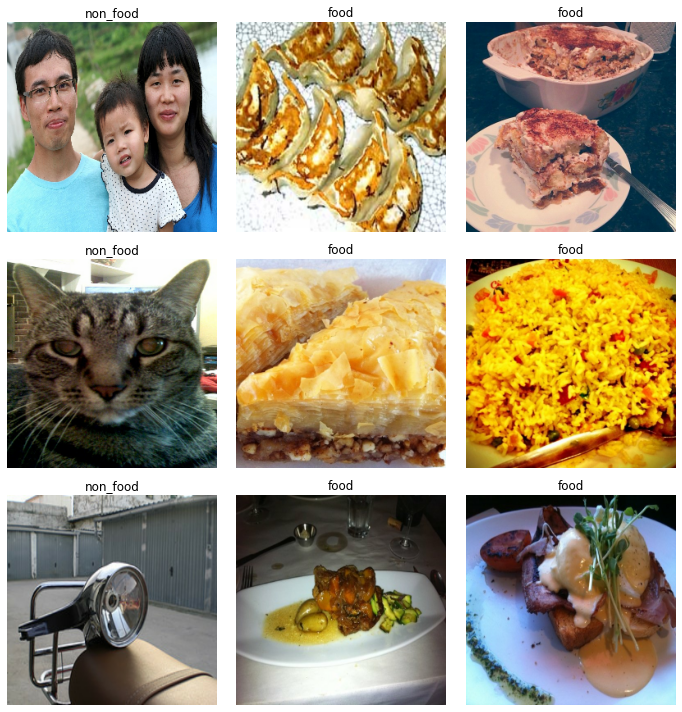

In [ ]:
# code from https://www.tensorflow.org/tutorials/images/classification
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")
        plt.tight_layout()

In [ ]:
# instantiating our model

model = Sequential()
# flattening our data to 1D
model.add(Flatten(input_shape=(256, 256, 3)))
# adding Dense layers with dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
# adding our final layer with the classes for nodes
model.add(Dense(n_classes, activation='sigmoid'))
# compiling our model
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam',
              metrics=['accuracy'])
# adding an early stop callback
early_stop = EarlyStopping(patience = 10)
# fitting and running our model
results = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=32, callbacks=early_stop, verbose=1)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.9731 - accuracy: 0.3750 - val_loss: 48.6569 - val_accuracy: 0.3750
Epoch 2/30
1/1 [==============================] - 0s 51ms/step - loss: 35.8724 - accuracy: 0.6250 - val_loss: 36.1496 - val_accuracy: 0.6250
Epoch 3/30
1/1 [==============================] - 0s 45ms/step - loss: 58.5310 - accuracy: 0.3750 - val_loss: 6.8585 - val_accuracy: 0.3750
Epoch 4/30
1/1 [==============================] - 0s 45ms/step - loss: 15.2224 - accuracy: 0.5312 - val_loss: 39.8421 - val_accuracy: 0.3750
Epoch 5/30
1/1 [==============================] - 0s 47ms/step - loss: 24.8473 - accuracy: 0.6250 - val_loss: 29.8960 - val_accuracy: 0.3750
Epoch 6/30
1/1 [==============================] - 0s 50ms/step - loss: 21.4475 - accuracy: 0.6250 - val_loss: 1.8831 - val_accuracy: 0.6875
Epoch 7/30
1/1 [==============================] - 0s 45ms/step - loss: 18.2891 - accuracy: 0.5312 - val_loss: 4.0561 - val_accuracy: 0.6875
Epoch 8/30
1/1 [===

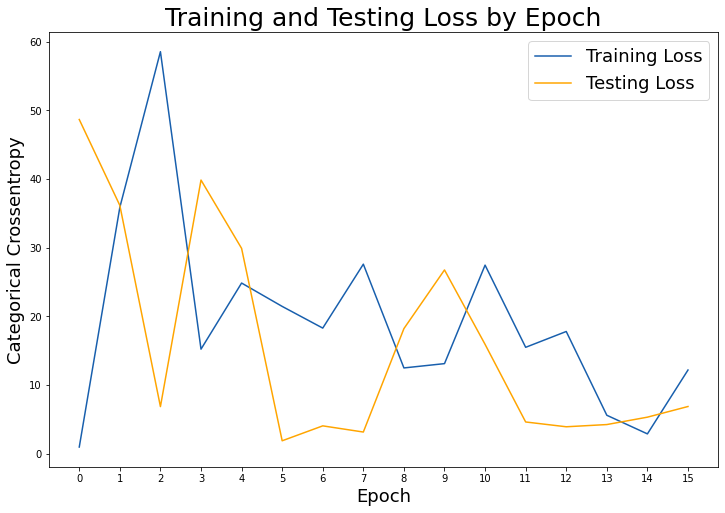

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = results.history['loss']
test_loss = results.history['val_loss']
epoch_labels = results.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

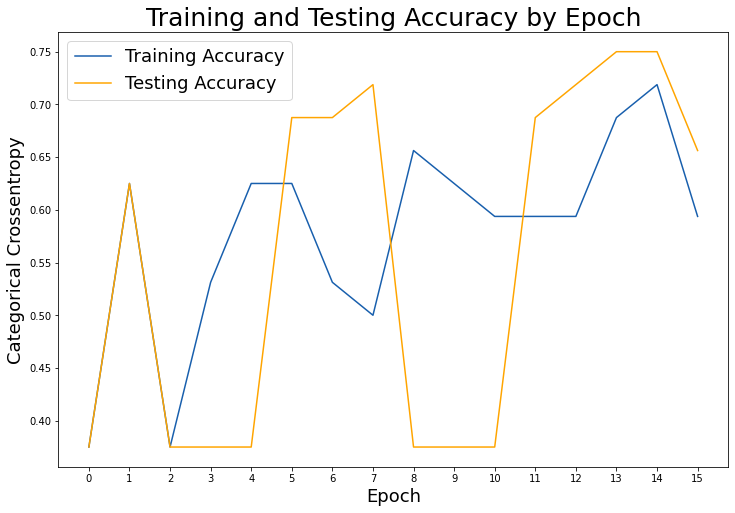

In [ ]:
# Check out our train loss and test loss over epochs.
train_acc = results.history['accuracy']
test_acc = results.history['val_accuracy']
epoch_labels = results.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test,
                       verbose=1)

labels = model.metrics_names

# Compare CNN and FFNN models.

print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

1/1 [==============================] - 0s 30ms/step - loss: 6.8735 - accuracy: 0.6562
FFNN loss : 6.87345027923584
FFNN accuracy  : 0.65625


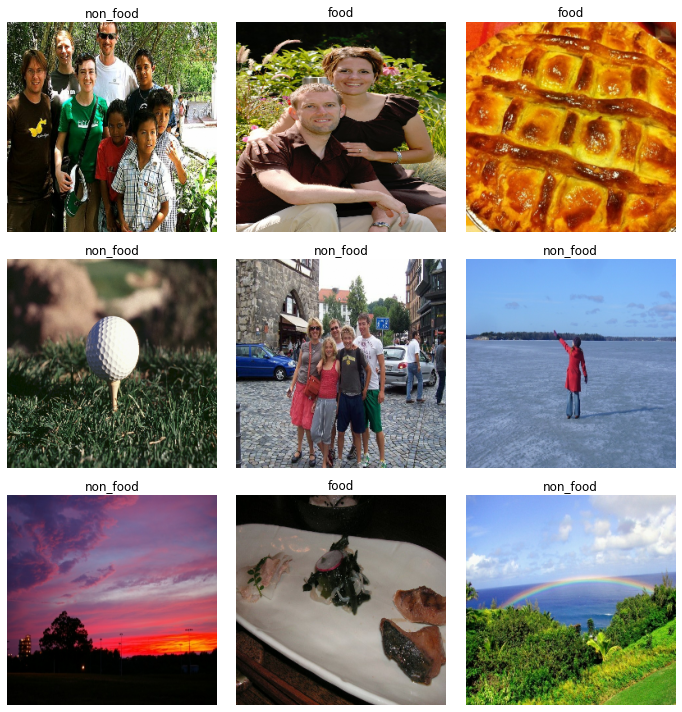

In [ ]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

### ** Interpretation **

The testing data accuracy is a bit all over the place and has a sharp decline at the last epoch. This model doesn't seem to be a good fit for the data. We will try a CNN below.

## Predicting using Convolutional Neural Network (CNN)

In [ ]:
# Instantiating CNN model
# code from lesson 8.03
cnn_model = Sequential()

# adding convolutional and pooling filter layers
# these layers will create filters over each image to detect edges and shapes
# conv layer 1
cnn_model.add(Conv2D(filters=6, # number of filters
                     kernel_size=(3,3),# height/width of filter
                     activation='relu', # activation function
                     data_format='channels_last',
                     input_shape=(input_shape)))

cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same')) # dimensions of region of pooling

# conv layer 2
# cnn_model.add(Conv2D(filters=6,
#                      kernel_size=(3,3),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 3
cnn_model.add(Conv2D(filters=8,
                     kernel_size=(3,3),
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 4
# cnn_model.add(Conv2D(filters=8,
#                      kernel_size=(3,3),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 5
# cnn_model.add(Conv2D(filters=6,
#                      kernel_size=(3,3),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 6
# cnn_model.add(Conv2D(filters=12,
#                      kernel_size=(4,4),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 7
# cnn_model.add(Conv2D(filters=16,
#                      kernel_size=(5,5),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 8
# cnn_model.add(Conv2D(filters=16,
#                      kernel_size=(5,5),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))


# flattening layers
cnn_model.add(Flatten())
# adding dense layers
cnn_model.add(Dense(256, activation='relu'))
# adding dropout to minimize overfitting
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
cnn_model.add(Dense(32, activation='relu'))
# final layer with number of classes as output
cnn_model.add(Dense(n_classes, activation='sigmoid'))

# compiling model with optimizer Adam and measuring for accuracy
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

# adding an early stop callback to end the model early if it starts to decline
early_stop = EarlyStopping(patience = 10)

# fitting and running the model
cnn_results = cnn_model.fit(X_train,y_train,
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            epochs=40,
                            callbacks=early_stop,
                            verbose=1,
                            workers=4)

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6879 - accuracy: 0.5938 - val_loss: 2.0100 - val_accuracy: 0.3750
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 1.1899 - accuracy: 0.6250 - val_loss: 0.7284 - val_accuracy: 0.6250
Epoch 3/40
1/1 [==============================] - 0s 53ms/step - loss: 0.9038 - accuracy: 0.4062 - val_loss: 0.9906 - val_accuracy: 0.3750
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.6007 - accuracy: 0.7188 - val_loss: 1.1703 - val_accuracy: 0.3750
Epoch 5/40
1/1 [==============================] - 0s 54ms/step - loss: 0.7110 - accuracy: 0.6562 - val_loss: 0.9389 - val_accuracy: 0.3750
Epoch 6/40
1/1 [==============================] - 0s 51ms/step - loss: 0.7571 - accuracy: 0.6562 - val_loss: 0.7155 - val_accuracy: 0.4688
Epoch 7/40
1/1 [==============================] - 0s 55ms/step - loss: 0.5325 - accuracy: 0.8125 - val_loss: 0.5471 - val_accuracy: 0.7500
Epoch 8/40
1/1 [=============

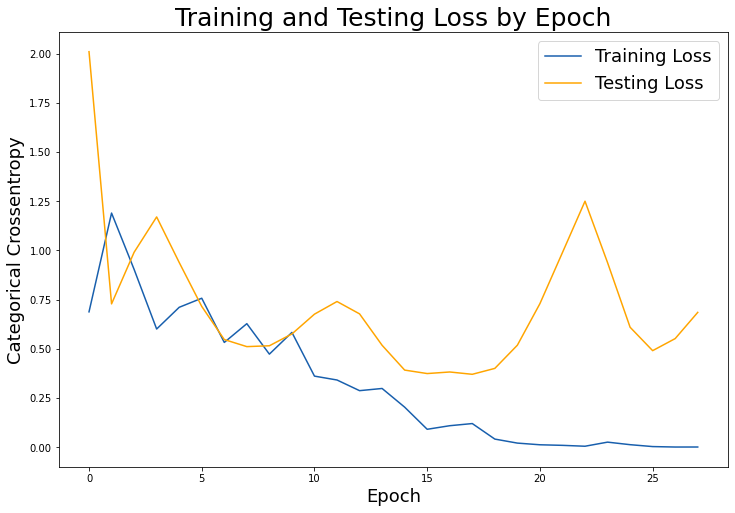

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = cnn_results.history['loss']
test_loss = cnn_results.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
# plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);

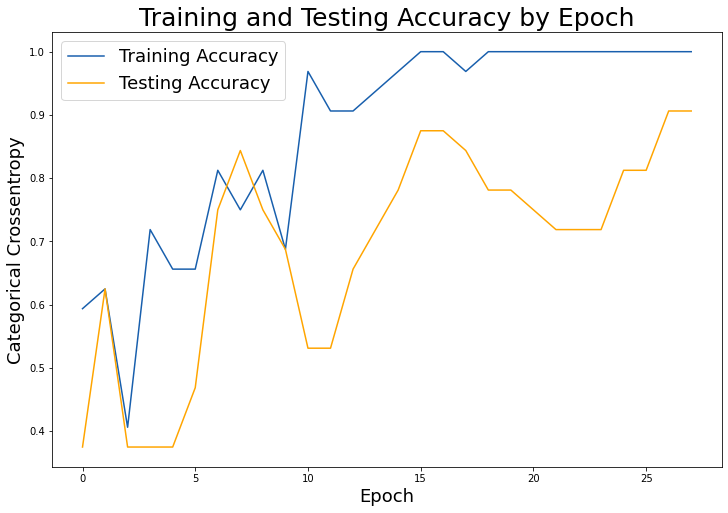

In [ ]:
# Check out our train loss and test loss over epochs.
train_acc = cnn_results.history['accuracy']
test_acc = cnn_results.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
# plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);

In [ ]:
# Evaluate model on test data.
cnn_score = cnn_model.evaluate(X_test, y_test,
                               verbose=1)

cnn_labels = cnn_model.metrics_names

# Compare CNN and FFNN models.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

1/1 [==============================] - 0s 31ms/step - loss: 0.6852 - accuracy: 0.9062
CNN loss  : 0.6852270364761353
CNN accuracy   : 0.90625

FFNN loss : 6.87345027923584
FFNN accuracy  : 0.65625


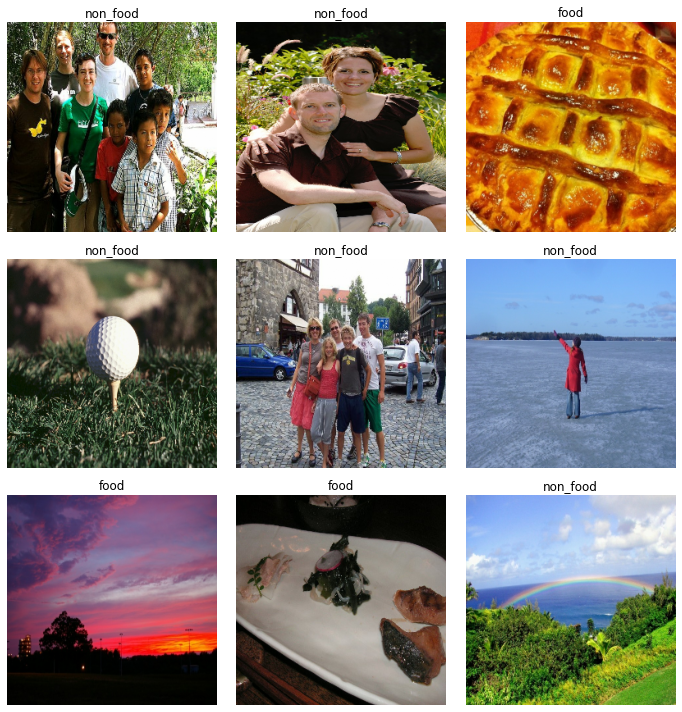

In [ ]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(cnn_model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_fnf_preds_cnn.png', bbox_inches='tight');

### ** Interpretation **

The CNN model, with 2 convolutional layers and 5 dense layers and 2 dropout layers, performed much better than our feed-forward neural network. 

# Predicting on our Data Using Pre-Trained Model

Our pre-trained model Xception (which was also trained on food images as well as other classes) is doing an okay job predicting this food item, we will use the pre-trained weights as the basis of our model below.

# Modeling with Neural Nets & Pre-trained Weights

In [ ]:
# creating a path variable for the data subset we'll be modeling on
img_path = "/content/drive/My Drive/Capstone/food-5k/training"
img_size = 299
img_size_tup = (299, 299)

# loading the images from the path into a train_data variable while resizing the images and splitting the data
# color mode will be 'rgb' which is 3 colors
# labels are 'categorical' since there are more than 2 categories
train_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path, 
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=None,
          # subset='training',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 2999 files belonging to 2 classes.


In [ ]:
# loading the images for validation from the above split into a test_data variable while resizing same as above 

img_path_val = "/content/drive/My Drive/Capstone/food-5k/validation"

test_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path_val,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=None,
          # subset='validation',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 1000 files belonging to 2 classes.


In [ ]:
# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
X_train, y_train = preprocess_img_input(train_data)
X_test, y_test = preprocess_img_input(test_data)

In [ ]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape_X = X_train[0].shape

[('n07697313', 'cheeseburger', 0.62343323),
 ('n07697537', 'hotdog', 0.09600645),
 ('n07684084', 'French_loaf', 0.08075303),
 ('n07693725', 'bagel', 0.031809255),
 ('n02776631', 'bakery', 0.024585187)]

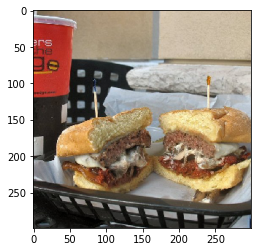

In [ ]:
# code from https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras

# instantiating the Xception pre-trained weights model
model = Xception(weights='imagenet')
# our image path to one of our dataset's images
img_path_single = "/content/drive/My Drive/Capstone/food-5k/training/food/1.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
plt.imshow(img)
# decoding the results into a list of tuples (class, description, probability)
decode_predictions(preds, top=5)[0]

## Modeling with Xception Pretrained Model

In [ ]:
# code from https://keras.io/api/optimizers/

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7,
    decay_steps=10000,
    decay_rate=0.7)

In [ ]:
# code help: https://keras.io/api/applications/
# code help: https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

# create the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)

for layer in X_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=X_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=10)

# train the model on the new data for a few epochs
X_results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32, callbacks=early_stop, workers=4)


Epoch 1/25
1/1 [==============================] - 3s 3s/step - loss: 0.7388 - accuracy: 0.4062 - val_loss: 0.8631 - val_accuracy: 0.4375
Epoch 2/25
1/1 [==============================] - 0s 295ms/step - loss: 0.4391 - accuracy: 0.7188 - val_loss: 2.2861 - val_accuracy: 0.6250
Epoch 3/25
1/1 [==============================] - 0s 288ms/step - loss: 4.5931 - accuracy: 0.4375 - val_loss: 8.7204 - val_accuracy: 0.3750
Epoch 4/25
1/1 [==============================] - 0s 290ms/step - loss: 5.0295 - accuracy: 0.6250 - val_loss: 0.4752 - val_accuracy: 0.7500
Epoch 5/25
1/1 [==============================] - 0s 288ms/step - loss: 0.6170 - accuracy: 0.6250 - val_loss: 0.7933 - val_accuracy: 0.4062
Epoch 6/25
1/1 [==============================] - 0s 287ms/step - loss: 0.4113 - accuracy: 0.7500 - val_loss: 0.3273 - val_accuracy: 0.8750
Epoch 7/25
1/1 [==============================] - 0s 288ms/step - loss: 0.4714 - accuracy: 0.7500 - val_loss: 0.7328 - val_accuracy: 0.4062
Epoch 8/25
1/1 [=======

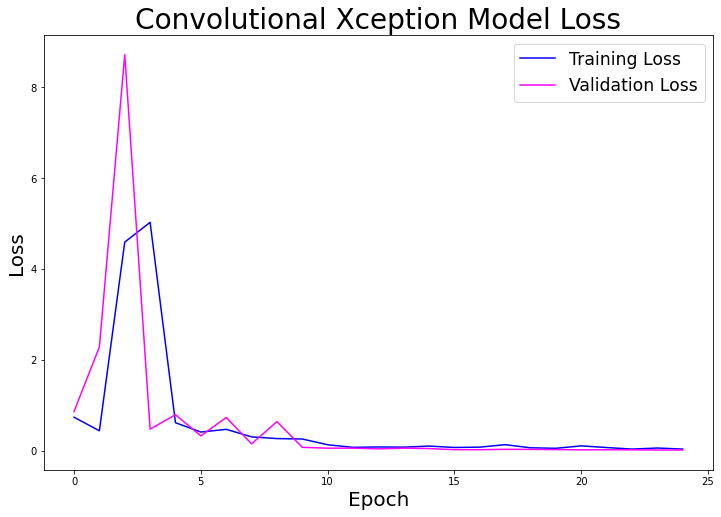

In [ ]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['loss'], label='Training Loss', color='blue')
plt.plot(X_results.history['val_loss'], label='Validation Loss', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_fnf.png', bbox_inches='tight');

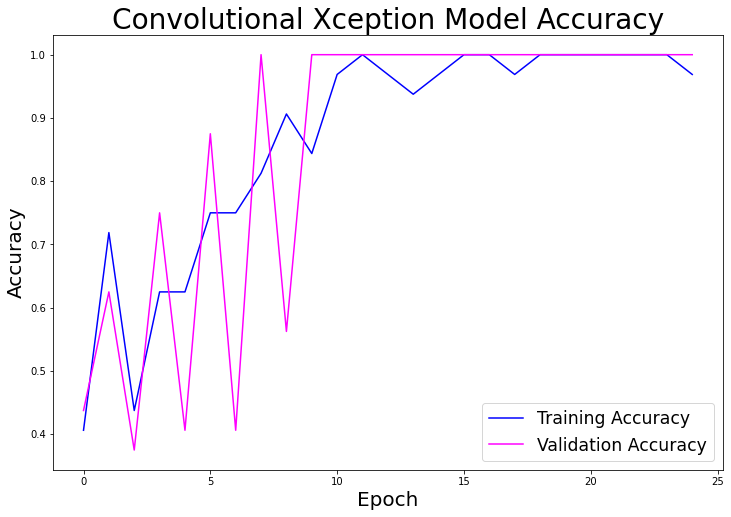

In [ ]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(X_results.history['val_accuracy'], label='Validation Accuracy', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
# plt.ylim(0, 1.00)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_fnf_.png', bbox_inches='tight');

In [ ]:
# evaluating on test data
X_score = model.evaluate(X_test, y_test, verbose=1)
X_labels = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')

1/1 [==============================] - 0s 155ms/step - loss: 0.0167 - accuracy: 1.0000
Xception loss  : 0.01673039421439171
Xception accuracy   : 1.0


** Interpretation **

The Xception pre-trained model performs the best on our dataset with 100% training and testing accuracy and a near-0 loss.

In [ ]:
# saving the model
from tensorflow.keras.models import load_model, clone_model
model.save("/content/drive/My Drive/Capstone/Xception_model_fnf.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_fnf.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://65809cd7-61b3-45a4-9f49-170b0f22f461/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
## code from lesson 9.04
# making predictions on X_test
preds_1 = np.argmax(model.predict(X_test), axis = 1)

# saving predictions to dataframe & output to .csv
X_test_pred_df_1 = pd.DataFrame({
    'Label': preds_1,
    'ImageId': range(1,X_test.shape[0] + 1)
})
X_test_pred_df_1.to_csv('/content/drive/My Drive/Capstone/X_preds_fnf.csv', index=False)

# Testing Our Model on Random Images

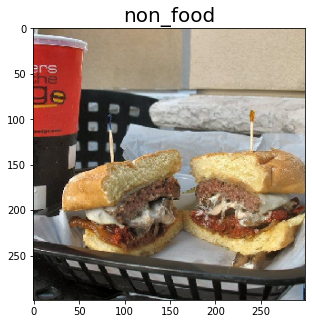

In [ ]:
# visualizing one prediction
plt.figure(figsize=(5,5))
# loading the image and preprocessing it for the model to predict it
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);


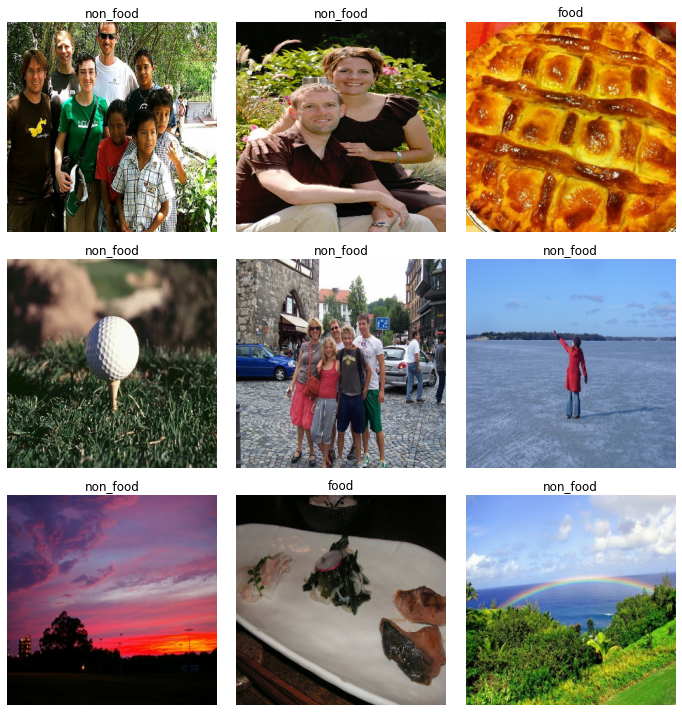

In [ ]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_fnf_preds_X.png', bbox_inches='tight');

Our Xception model performs extremely well on our Food-5k dataset. We are able to achieve 100% on training and testing with extremely low loss. Below we will evaluate it on new data.

In [ ]:

img_path_eval = "/content/drive/My Drive/Capstone/food-5k/evaluation"

batchloader_eval = tf.keras.preprocessing.image_dataset_from_directory(
          img_path_eval,
          labels='inferred',
          label_mode='categorical',
          class_names=['food', 'non_food'],
          color_mode='rgb',
          batch_size=32,
          image_size=(256, 256),
          shuffle=True,
          seed=13,
          validation_split=None,
          subset=None,
          interpolation='bilinear',
          follow_links=False,
          crop_to_aspect_ratio=True
)

Found 995 files belonging to 2 classes.


In [ ]:
X_eval, y_eval = preprocess_img_input(batchloader_eval)

In [ ]:
# Evaluate model on test data.
Xception__score = model.evaluate(X_test, y_test, verbose=1)
Xception__eval_score = model.evaluate(X_eval, y_eval, verbose=1)

# printing Xception scores
print(f'Xception on test data {X_labels[0]}  : {X_score[0]}')
print(f'Xception on test data {X_labels[1]}   : {X_score[1]}')
# printing Xception scores
print(f'Xception on New Data {X_labels[0]}  : {X_score[0]}')
print(f'Xception on New Data {X_labels[1]}   : {X_score[1]}')

1/1 [==============================] - 1s 1s/step - loss: 0.0457 - accuracy: 1.0000
Xception on test data loss  : 0.01673039421439171
Xception on test data accuracy   : 1.0
Xception on New Data loss  : 0.01673039421439171
Xception on New Data accuracy   : 1.0


Even on new data, we've achieved 100%!

# Conclusions & Recommendations

Xception performs the best out of the 3 models we used for our Food-5k dataset.